In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sqlalchemy import text
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import sys
import os

# Subir tres niveles desde tfm/teams/frankfurt/ hasta data/
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
sys.path.insert(0, project_root)

from database.connection import get_db_manager

In [2]:
# Configuration
TABLE_TYPE = 'domestic'
LEAGUES = ['ENG-Premier League', 'ESP-La Liga', 'ITA-Serie A', 'GER-Bundesliga', 'FRA-Ligue 1']
SEASON = '2223'
MIN_MINUTES = 800

FRANKFURT_COLORS = {
    'primary': '#E1000F',
    'secondary': '#000000'
}

PSG_COLORS = {
    'primary': '#0066CC',
    'secondary': '#DA291C'
}

FW_PLAYERS = [
    {'name': 'Randal Kolo Muani', 'search': 'Kolo Muani', 'pos': 'FW', 'team': 'Eint Frankfurt'},
    {'name': 'Hugo Ekitike', 'search': 'Ekitike', 'pos': 'FW', 'team': 'Paris S-G'},
]

SAVE_PATH_BASE = "./kolo_muani_ekitike_radars/"
os.makedirs(SAVE_PATH_BASE, exist_ok=True)

In [3]:
# Conexión BD
db = get_db_manager()

league_list_str = "', '".join(LEAGUES)
query = f"""
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    nationality,
    age,
    fbref_metrics,
    understat_metrics
FROM footballdecoded.players_{TABLE_TYPE} p
WHERE p.league IN ('{league_list_str}')
AND p.season = '{SEASON}'
ORDER BY p.league, p.season DESC, p.team, p.player_name
"""

df_raw = pd.read_sql(query, db.engine)
db.close()

print(f"Extraídos: {df_raw.shape[0]} registros, {df_raw.shape[1]} columnas")
df_raw.head()

2026-01-05 14:48:45,820 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2026-01-05 14:48:46,355 - database.connection - INFO - Database connection successful


Extraídos: 2801 registros, 10 columnas


,unique_player_id,player_name,team,league,season,position,nationality,age,fbref_metrics,understat_metrics
0,3812f10db382a575,Aaron Ramsdale,Arsenal,ENG-Premier League,2223,GK,ENG,24,"{'CS': '14', 'FK': '0', 'OG': '0', '/90': '-0....","{'understat_xa': '0.0', 'understat_team': 'Ars..."
1,5667bbe8a1e88932,Albert Sambi Lokonga,Arsenal,ENG-Premier League,2223,MF,BEL,22,"{'FK': '0', 'OG': '0', 'Crs': '0', 'Fld': '5',...","{'understat_xa': '0.04567850008606911', 'under..."
2,4297cac0772af3c8,Ben White,Arsenal,ENG-Premier League,2223,DF,ENG,24,"{'CS': '0', 'FK': '0', 'OG': '0', '/90': '0.44...","{'understat_xa': '4.293553752824664', 'underst..."
3,258ed61985702bb2,Bukayo Saka,Arsenal,ENG-Premier League,2223,FW,ENG,20,"{'FK': '1', 'OG': '0', 'Crs': '172', 'Fld': '6...","{'understat_xa': '7.0429807445034385', 'unders..."
4,7e4915975dddbf21,Cédric Soares,Arsenal,ENG-Premier League,2223,DF,POR,30,"{'FK': '0', 'OG': '0', 'Crs': '3', 'Fld': '0',...","{'understat_xa': '0.13160278275609016', 'under..."


In [4]:
# Filtrar por minutos mínimos Y posición FW
df_filtered = df_raw[
    (df_raw['fbref_metrics'].apply(
        lambda x: x.get('minutes_played', 0) if x else 0
    ) >= MIN_MINUTES) &
    (df_raw['position'].str.contains('FW', case=False, na=False))
].copy()

print(f"Filtro {MIN_MINUTES}+ min + FW: {df_filtered.shape[0]} jugadores")

Filtro 800+ min + FW: 525 jugadores


In [5]:
def extract_metrics(df, col_name):
    result = pd.DataFrame(index=df.index)
    
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 5:
            result[key] = values
    
    return result

def _convert_to_float(value):
    if isinstance(value, (int, float)):
        return float(value)
    
    if value is None or pd.isna(value):
        return np.nan
    
    if isinstance(value, str):
        if value.strip() == '':
            return np.nan
        
        if value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    
    return np.nan

In [6]:
# Extraer métricas numéricas
fbref_nums = extract_metrics(df_filtered, 'fbref_metrics')
understat_nums = extract_metrics(df_filtered, 'understat_metrics')
print(f"FBref: {fbref_nums.shape[1]} métricas | Understat: {understat_nums.shape[1]} métricas")

FBref: 185 métricas | Understat: 10 métricas


In [7]:
# Métricas a excluir de normalización
exclude_normalization = {
    'minutes_played', 'age', 'birth_year', 'games_started', 'minutes_per_game',
    'minutes_per_start', 'games', 'games_subs', 'unused_sub', 'points_per_game',
    'on_goals_for', 'on_goals_against', 'plus_minus', 'plus_minus_per90',
    'plus_minus_wowy', 'on_xg_for', 'on_xg_against', 'xg_plus_minus',
    'xg_plus_minus_per90', 'xg_plus_minus_wowy', 'Touches_Touches',
    'pass_completion_pct', 'shots_on_target_pct', 'Take-Ons_Succ%', 'Take-Ons_Tkld%', 
    'Aerial Duels_Won%', 'Challenges_Tkl%', 'Save%', 'Launched_Cmp%', 'Crosses_Stp%',
    'shots_per_90', 'GA90', 'GCA_GCA90', 'SCA_SCA90', 'Team Success_+/-90', 'SoT/90',
    'npxG/Sh', 'xG+xAG', 'non_penalty_xG_plus_xAG', 'avg_shot_distance', 'minutes_per_match',
    'Passes_AvgLen', 'Goal Kicks_AvgLen', 'Starts_Mn/Start', 'Subs_Mn/Sub', 'Min%',
    'matches_played', 'matches_started', 'wins', 'draws', 'losses',
    'understat_buildup_involvement_pct', 'understat_player_id', 'understat_team_id', 
    'CS%', 'CS', 'PSxG+/-', 'PSxG', 'Save_Save%',
    "Sweeper_#OPA", 'Sweeper_#OPA/90', 'Sweeper_AvgDist', "Goal Kicks_Launch%", 'G-xG'
}

# Calcular per100touches FBref
fbref_per100 = fbref_nums.loc[:, ~fbref_nums.columns.isin(exclude_normalization)]
fbref_per100 = (fbref_per100.div(fbref_nums['Touches_Touches'], axis=0) * 100).round(3)
fbref_per100.columns = [f'{col}_per100touches' for col in fbref_per100.columns]

# Calcular per100touches Understat
understat_per100 = understat_nums.loc[:, ~understat_nums.columns.isin(exclude_normalization)]
understat_per100 = (understat_per100.div(fbref_nums['Touches_Touches'], axis=0) * 100).round(3)
understat_per100.columns = [f'{col}_per100touches' for col in understat_per100.columns]

print(f"Per100touches: {fbref_per100.shape[1]} + {understat_per100.shape[1]}")

# COMBINAR todas las métricas
all_metrics = pd.concat([fbref_nums, understat_nums, fbref_per100, understat_per100], axis=1)

Per100touches: 144 + 7


In [8]:
# Calcular percentiles
all_percentiles = all_metrics.rank(pct=True) * 98 + 1
all_percentiles = all_percentiles.round(0).astype('Int64')
all_percentiles.columns = [f'{col}_pct' for col in all_percentiles.columns]

print(f"Métricas totales: {all_metrics.shape[1]}")
print(f"Percentiles totales: {all_percentiles.shape[1]}")

Métricas totales: 346
Percentiles totales: 346


In [9]:
# DataFrame final consolidado
base_cols = ['unique_player_id', 'player_name', 'team', 'league', 'season', 'position']

df_final = pd.concat([
    df_filtered[base_cols],
    all_metrics,
    all_percentiles
], axis=1)

print(f"DataFrame final: {df_final.shape[0]} filas, {df_final.shape[1]} columnas")

# Limpieza de Series anidados
def clean_series_values(df):
    for col in df.columns:
        series_mask = df[col].apply(lambda x: isinstance(x, pd.Series))
        if series_mask.any():
            df[col] = df[col].apply(
                lambda x: x.iloc[0] if isinstance(x, pd.Series) and not x.empty else x
            )
    return df

df_final = clean_series_values(df_final)

# Eliminar columnas problemáticas
problem_cols = ['shots_on_target_pct']
df_final = df_final.drop(columns=[col for col in problem_cols if col in df_final.columns])

print(f"Limpieza completada: {df_final.shape[1]} columnas finales")

DataFrame final: 525 filas, 698 columnas
Limpieza completada: 696 columnas finales


In [10]:
# Search FW players
player_ids = {}

print("FORWARD PLAYER SEARCH:")
print("=" * 50)

for player_config in FW_PLAYERS:
    player_name = player_config['name']
    search_pattern = player_config['search']
    
    search_results = df_filtered[
        df_filtered['player_name'].str.contains(search_pattern, case=False, na=False)
    ]
    
    if len(search_results) > 0:
        print(f"\n{player_name} - search: '{search_pattern}':")
        for _, p in search_results.iterrows():
            minutes = p['fbref_metrics'].get('minutes_played', 0) if isinstance(p['fbref_metrics'], dict) else 0
            print(f"  {p['unique_player_id']} - {p['player_name']} ({p['team']}, {p['league']}, {p['position']}) - {minutes} min")
            
            if player_name not in player_ids:
                player_ids[player_name] = p['unique_player_id']
                print(f"  ✓ ASSIGNED: {player_name} -> {p['unique_player_id']}")
                break
    else:
        print(f"\n{player_name}: NOT FOUND")

print("\n" + "=" * 50)
print("PLAYERS FOUND:")
for name, player_id in player_ids.items():
    print(f"  {name}: {player_id}")

if len(player_ids) == 2:
    print(f"\n✓ ALL PLAYERS FOUND")
else:
    print(f"\n✗ MISSING PLAYERS")

FORWARD PLAYER SEARCH:

Randal Kolo Muani - search: 'Kolo Muani':
  8cfbfca3e5dc4ba0 - Randal Kolo Muani (Eint Frankfurt, GER-Bundesliga, FW) - 2631.0 min
  ✓ ASSIGNED: Randal Kolo Muani -> 8cfbfca3e5dc4ba0

Hugo Ekitike - search: 'Ekitike':
  2af83c0acb2812de - Hugo Ekitike (Paris S-G, FRA-Ligue 1, FW) - 1155.0 min
  ✓ ASSIGNED: Hugo Ekitike -> 2af83c0acb2812de

PLAYERS FOUND:
  Randal Kolo Muani: 8cfbfca3e5dc4ba0
  Hugo Ekitike: 2af83c0acb2812de

✓ ALL PLAYERS FOUND


In [11]:
# FW Centro metrics configuration
fw_metrics = [
    'expected_goals_per100touches', 'goals_per100touches', 'shots_per100touches', 'Touches_Att Pen_per100touches',
    'expected_assists_per100touches', 'Take-Ons_Succ_per100touches', 'npxG/Sh', 'G-xG',
    'Fld_per100touches', 'SCA_SCA90'
]
fw_titles = [
    'Expected Goals', 'Goals', 'Shots', 'Touches in Box',
    'Expected Assists', 'Dribbles', 'npxG per Shot', 'Goals - xG',
    'Fouls Drawn', 'Shot Creating Actions'
]

METRICS_BY_POSITION = {
    'fw_st': {'metrics': fw_metrics, 'titles': fw_titles}
}

print("FW METRICS VERIFICATION:")
print("=" * 50)
for position, config in METRICS_BY_POSITION.items():
    metrics_count = len(config['metrics'])
    titles_count = len(config['titles'])
    status = "OK" if metrics_count == 10 and titles_count == 10 else "ERROR"
    print(f"{status} {position}: {metrics_count} metrics, {titles_count} titles")

FW METRICS VERIFICATION:
OK fw_st: 10 metrics, 10 titles


In [12]:
# Kolo Muani vs Ekitike comparison configuration
COMPARISON = {
    'name': 'Kolo_Muani_vs_Ekitike',
    'player1': 'Randal Kolo Muani',
    'player2': 'Hugo Ekitike', 
    'position_type': 'FW_ST',
    'metrics_key': 'fw_st',
    'title': 'Randal Kolo Muani vs Hugo Ekitike (22/23)',
    'faces': ['/home/jaime/FD/data/blog/caras/tfm/kolo.png', '/home/jaime/FD/data/blog/caras/tfm/ekitike.png'],
    'colors': [FRANKFURT_COLORS['primary'], PSG_COLORS['primary']]
}

print(f"COMPARISON: {COMPARISON['title']}")
print(f"\nMETRICS BY POSITION:")
for position, config in METRICS_BY_POSITION.items():
    metrics_count = len(config['metrics'])
    titles_count = len(config['titles'])
    status = "OK" if metrics_count == 10 and titles_count == 10 else "ERROR"
    print(f"{status} {position}: {metrics_count} metrics, {titles_count} titles")

COMPARISON: Randal Kolo Muani vs Hugo Ekitike (22/23)

METRICS BY POSITION:
OK fw_st: 10 metrics, 10 titles


FW/ST PLAYER RADAR GENERATION

Processing: Randal Kolo Muani vs Hugo Ekitike (22/23)
  Dataset: 525 players (FW)
  Teams: Eint Frankfurt vs Paris S-G
  Colors: ['#E1000F', '#0066CC']
  ✓ Completed: Kolo_Muani_vs_Ekitike_combined.png


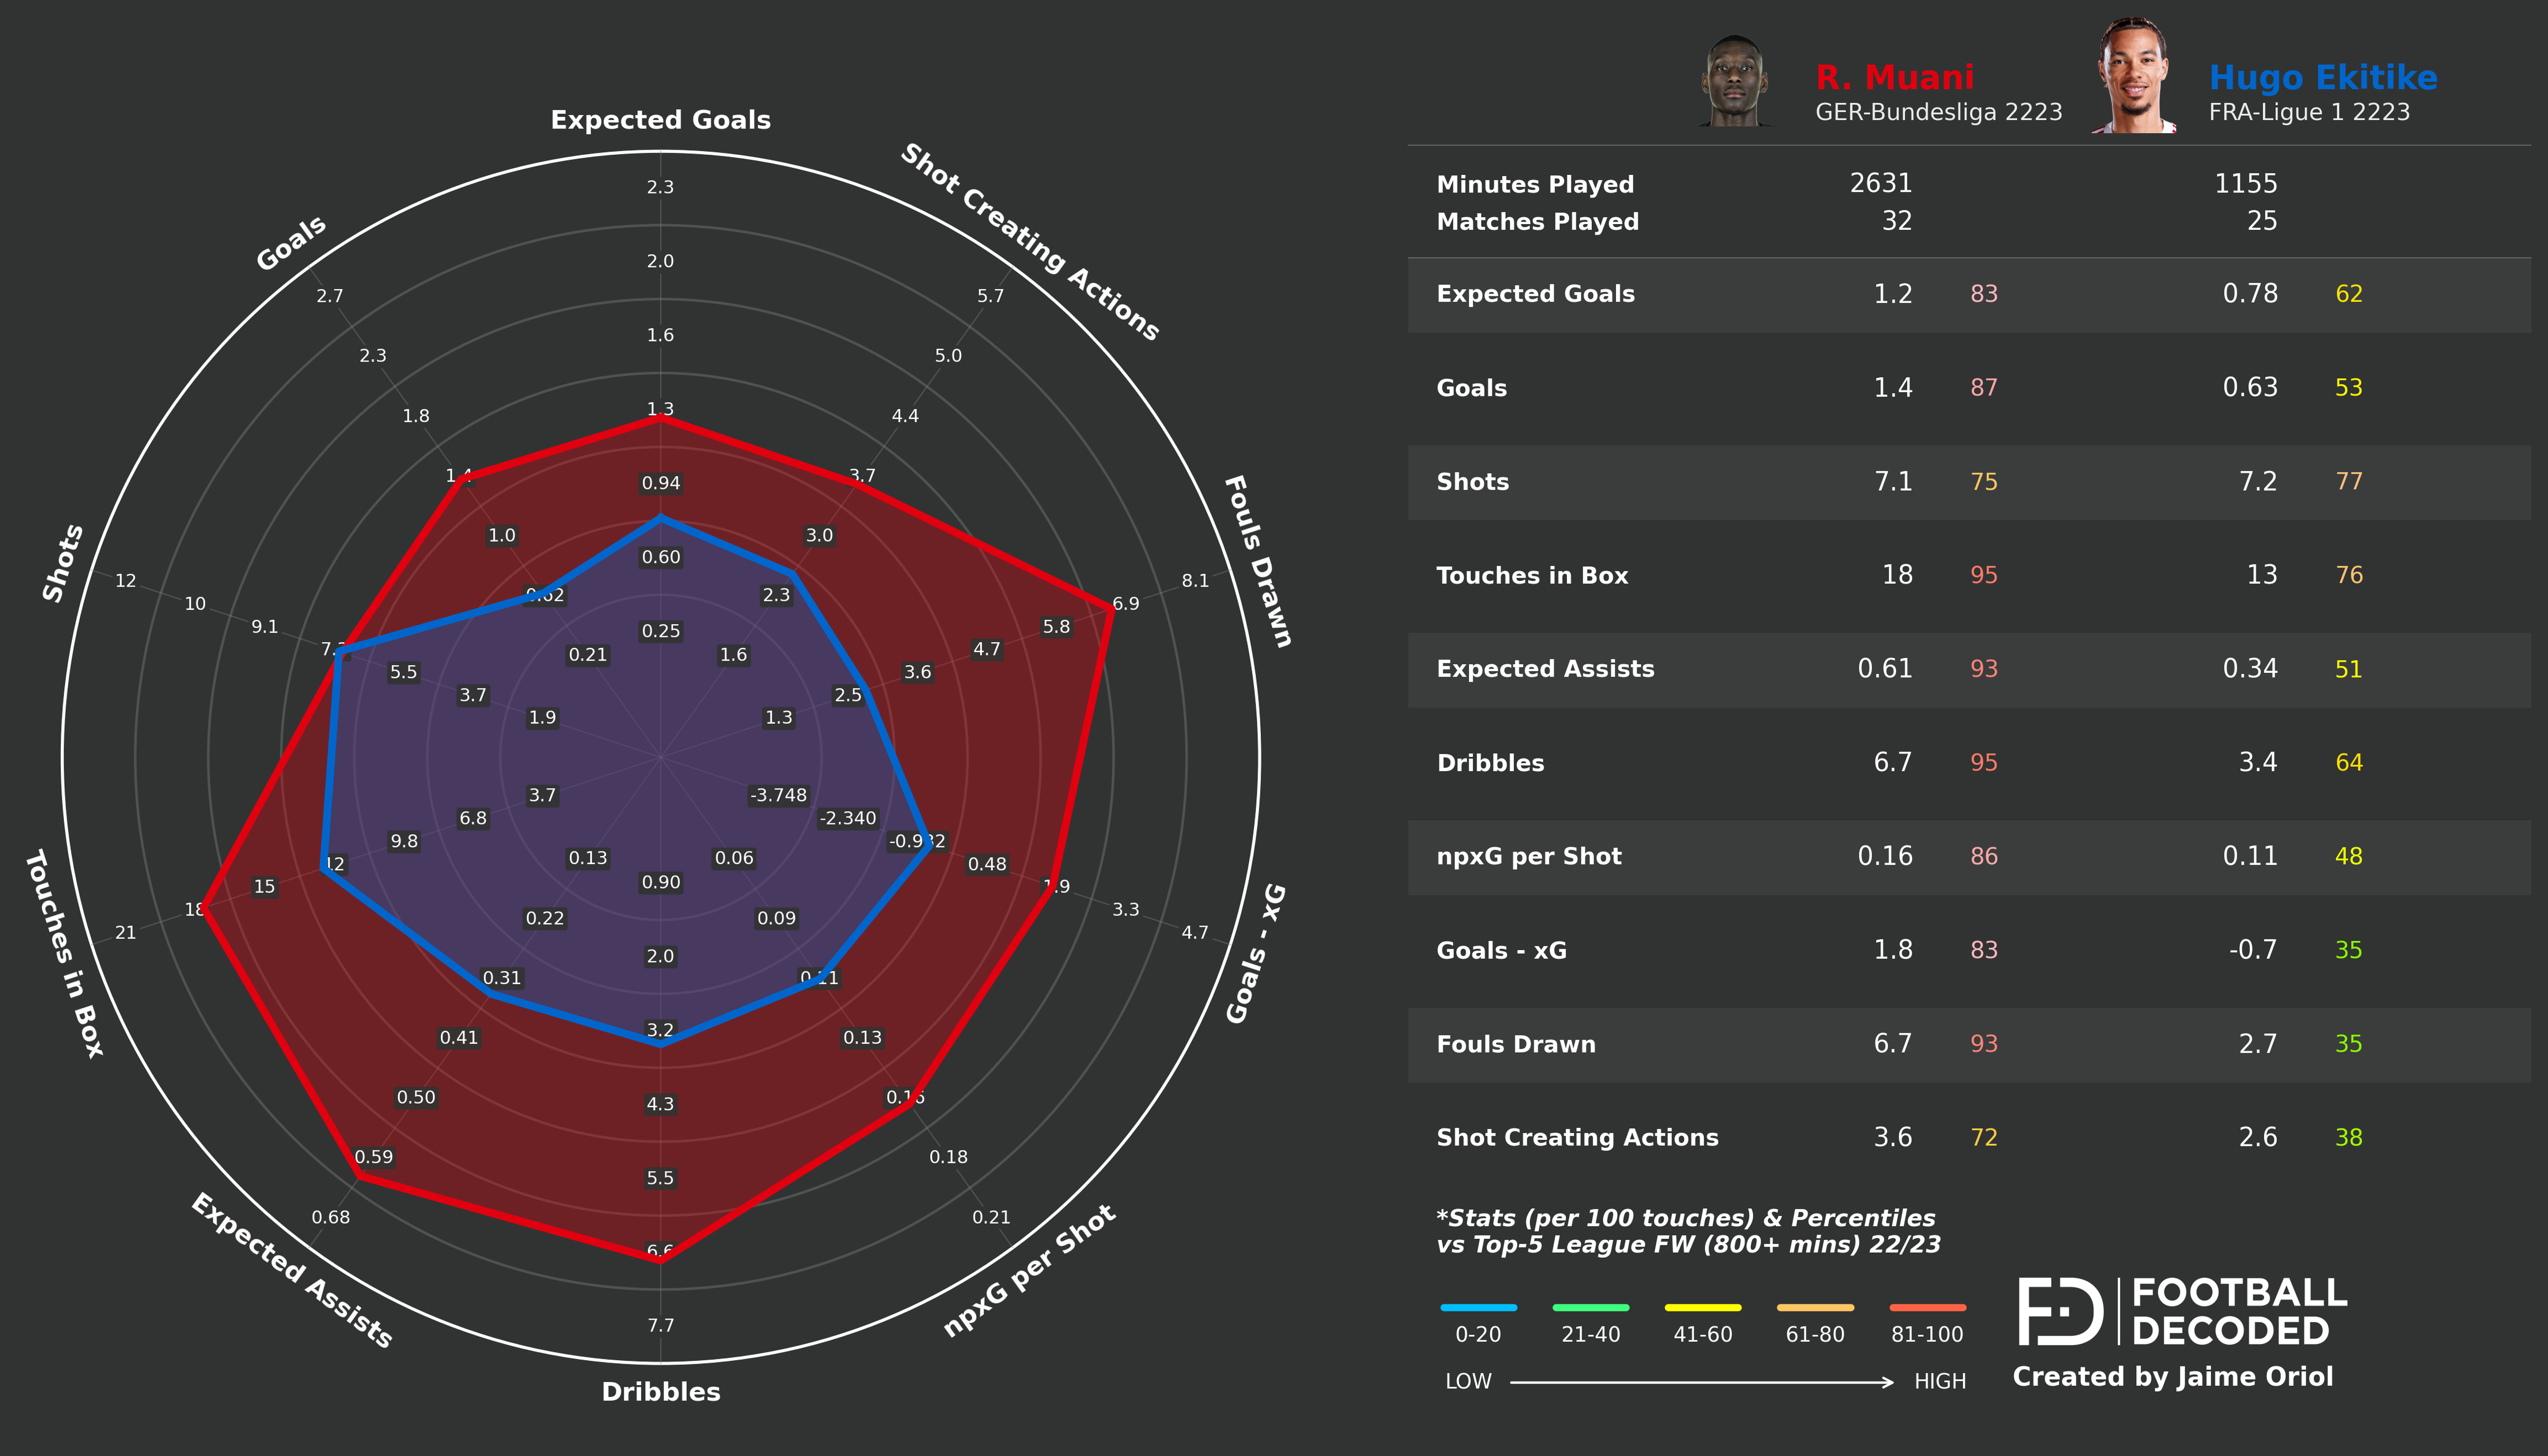


RADAR COMPARISON SUMMARY
✓ Radar generated successfully
Files saved in: ./kolo_muani_ekitike_radars/


In [13]:
from viz.swarm_radar import create_player_radar
from viz.stats_radar import create_stats_table, combine_radar_and_table
from IPython.display import Image as IPImage, display

print("FW/ST PLAYER RADAR GENERATION")
print("=" * 50)

comparison = COMPARISON
config_name = comparison['name']
player1_name = comparison['player1'] 
player2_name = comparison['player2']
title = comparison['title']
faces = comparison['faces']
colors = comparison['colors']
metrics_key = comparison['metrics_key']

print(f"\nProcessing: {title}")

if player1_name not in player_ids or player2_name not in player_ids:
    print(f"Missing player ID")
    print(f"  {player1_name}: {'Found' if player1_name in player_ids else 'Missing'}")
    print(f"  {player2_name}: {'Found' if player2_name in player_ids else 'Missing'}")
else:
    player1_id = player_ids[player1_name]
    player2_id = player_ids[player2_name]
    
    metrics_config = METRICS_BY_POSITION[metrics_key]
    metrics = metrics_config['metrics']
    metric_titles = metrics_config['titles']
    
    # Dataset FW
    position_df = df_final[df_final['position'].str.contains('FW', case=False, na=False)].copy()
    position_filter = "FW"
    
    print(f"  Dataset: {position_df.shape[0]} players ({position_filter})")
    
    # Team names
    player1_team = df_final.loc[df_final['unique_player_id'] == player1_id, 'team'].iloc[0]
    player2_team = df_final.loc[df_final['unique_player_id'] == player2_id, 'team'].iloc[0]
    
    team_colors = colors
    team_logos = {}
    if faces[0]:
        team_logos[player1_team] = faces[0]
    if len(faces) > 1 and faces[1]:
        team_logos[player2_team] = faces[1]
    
    print(f"  Teams: {player1_team} vs {player2_team}")
    print(f"  Colors: {colors}")
    
    try:
        create_player_radar(
            df_data=position_df,
            player_1_id=player1_id,
            player_2_id=player2_id,
            metrics=metrics,
            metric_titles=metric_titles,
            team_colors=team_colors,
            save_path=f"{SAVE_PATH_BASE}{config_name}_radar.png",
            use_swarm=False,
            show_plot=False
        )
        
        create_stats_table(
            df_data=position_df,
            player_1_id=player1_id,
            player_2_id=player2_id,
            metrics=metrics,
            metric_titles=metric_titles,
            team_colors=team_colors,
            team_logos=team_logos,
            save_path=f"{SAVE_PATH_BASE}{config_name}_table.png",
            footer_text=f"Stats (per 100 touches) & Percentiles\nvs Top-5 League {position_filter} ({MIN_MINUTES}+ mins) 22/23",
            show_plot=False
        )
        
        combine_radar_and_table(
            radar_path=f"{SAVE_PATH_BASE}{config_name}_radar.png",
            table_path=f"{SAVE_PATH_BASE}{config_name}_table.png", 
            output_path=f"{SAVE_PATH_BASE}{config_name}_combined.png"
        )
        
        print(f"  ✓ Completed: {config_name}_combined.png")
        
        display(IPImage(f"{SAVE_PATH_BASE}{config_name}_combined.png"))
        
        print("\n" + "=" * 50)
        print("RADAR COMPARISON SUMMARY")
        print("=" * 50)
        print(f"✓ Radar generated successfully")
        print(f"Files saved in: {SAVE_PATH_BASE}")
        
    except Exception as e:
        print(f"  ✗ Error: {str(e)}")
        import traceback
        traceback.print_exc()